<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/AUEM/Taller_20241219/ESE_ANN_simple_L8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensayo 2024.12.19
## Ensenada
* Cargar Numpy arrays de predictores y variables categoricas de Google Drive
* Preparar los datos y normalizar predictores con StandardScaler
* Subdividir datos de entrenamiento, control y validación
* Entrenar dos modelos ANN para comparar
* Evaluar modelos obtenidos
* Realizar predicción con mejor modelo
* Guardar resultados en Google Drive en Numpy array y en GeoTIFF

In [1]:
## Definir variables

## Prefilo de zona
prefijo = "ESE"

## Ruta en Google Drive (se requiere crear una carpeta en raíz de Google Drive)
ruta = "Colab Data"

## Variables requeridos para guardar en GeoTIFF

## Proyeccion UTM aplicable
projection_text = "EPSG:32611"

## limites de rectangulo de zona de estudio en UTM
limites_utm = [523989, 548709, 3502560, 3532709]

## tamaño de pixel
pixel = 30

#### Preparar el entorno

In [2]:
import random
from google.colab import drive
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
import tensorflow as tf
from tensorflow import keras
from osgeo import gdal, osr

!pip install pyrsgis
from pyrsgis import raster, convert


random_seed = 2
random.seed(random_seed)

## Inicializar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Lectura de datos de Google Drive

In [3]:
ruta_L8_2014 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2014_feature_L8_6b.npy"
print(ruta_L8_2014)

ruta_L8_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_feature_L8_6b.npy"
print(ruta_L8_2015)

ruta_L8_2020 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2020_feature_L8_6b.npy"
print(ruta_L8_2020)

ruta_target_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target.npy"
print(ruta_target_2015)

ruta_target_binary_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target_binary.npy"
print(ruta_target_binary_2015)

array_feature_2015 = np.load(ruta_L8_2015)
array_feature_2014 = np.load(ruta_L8_2014)
array_feature_2020 = np.load(ruta_L8_2020)
array_target_binary_2015 = np.load(ruta_target_2015)
array_target_2015 = np.load(ruta_target_2015)

/content/drive/MyDrive/Colab Data/ESE_2014_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2015_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2020_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target_binary.npy


#### Transformar datos para trabajo con el modelo

In [4]:
def feature_transform(source_array):
    print('Forma de array original:', source_array.shape)
    array_t = np.transpose(source_array, (2, 0, 1))
    table_array = convert.array_to_table(array_t)
    print('Forma de array transformada:', table_array.shape)
    return table_array

x_features_2020 = feature_transform(array_feature_2020)
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

Forma de array original: (1005, 824, 6)
Forma de array transformada: (828120, 6)
Forma de array original: (1005, 824, 6)
Forma de array transformada: (828120, 6)
Forma de array original: (1005, 824, 6)
Forma de array transformada: (828120, 6)
Forma de array original: (1005, 824, 1)
Forma de array transformada: (828120, 1)
Forma de array original: (1005, 824, 1)
Forma de array transformada: (828120, 1)


#### Estandarización de datos (predictores) con StandardScaler

In [5]:
scale = StandardScaler()
x_features_2020_n = scale.fit_transform(x_features_2020)
x_features_2014_n = scale.fit_transform(x_features_2014)
x_features_2015_n = scale.fit_transform(x_features_2015)

#### Visualización de patron de datos antes y despues de estandarización

In [6]:
print('Antes de normalización (2015)')
for arr in np.transpose(x_features_2015, (1, 0)): #do not need the loop at this point, but looks prettier
    print(stats.describe(arr))

print('\nDespues de normalización (2015)')
for arr in np.transpose(x_features_2015_n, (1, 0)): #do not need the loop at this point, but looks prettier
    print(stats.describe(arr))

Antes de normalización (2015)
DescribeResult(nobs=828120, minmax=(0, 32167), mean=8957.648926484084, variance=1743580.2425243778, skewness=0.5950405498123804, kurtosis=6.916813817671194)
DescribeResult(nobs=828120, minmax=(0, 39552), mean=9806.728715645075, variance=3270620.35809146, skewness=0.5030234151960464, kurtosis=2.398393683878586)
DescribeResult(nobs=828120, minmax=(0, 39440), mean=10231.844886006858, variance=6075291.113241147, skewness=0.37283425252380475, kurtosis=0.07214886109057694)
DescribeResult(nobs=828120, minmax=(0, 41874), mean=12576.697047529344, variance=15283293.250496583, skewness=-0.2077695828560707, kurtosis=-1.0628401381366914)
DescribeResult(nobs=828120, minmax=(0, 54777), mean=13606.169208568806, variance=20931125.726631857, skewness=-0.1462240028031699, kurtosis=-1.201507828531927)
DescribeResult(nobs=828120, minmax=(0, 56684), mean=12377.106735738782, variance=14557017.107871726, skewness=0.060302106552798884, kurtosis=-0.9952350552900113)

Despues de nor

#### Seperar subconjuntos de entrenamiento, validación y control

In [7]:
xTrain, xPreTest, yTrain, yPreTest = train_test_split(x_features_2015_n, y_labels_2015, test_size=0.2, random_state=random_seed)
xTest, xValidate, yTest, yValidate = train_test_split(xPreTest, yPreTest, test_size=0.5, random_state=random_seed)

xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xValidate = xValidate.reshape((xValidate.shape[0], 1, xValidate.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print('Tamaño de datos de entrenamiento')
print(xTrain.shape)
print(yTrain.shape)

print('Tamaño de datos de validación')
print(xValidate.shape)
print(yValidate.shape)

print('Tamaño de datos de control')
print(xTest.shape)
print(yTest.shape)

Tamaño de datos de entrenamiento
(662496, 1, 6)
(662496, 1)
Tamaño de datos de validación
(82812, 1, 6)
(82812, 1)
Tamaño de datos de control
(82812, 1, 6)
(82812, 1)


#### Definición de funciones auxiliares para el modelado

In [8]:
histories = {}
nBands = array_feature_2015.shape[2]

def model_fit(model, train_x, train_y, val_x, val_y, epochs, batch):
  history = model.fit(
    train_x,
    train_y,
    epochs=epochs,
    validation_data=(val_x, val_y),
    batch_size=batch,
    verbose=1)
  return history

### Entrenar modelo ANN con hiperparametros ver. 1 (M1)

In [9]:
## Configurar el modelo
M1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
M1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print('TensorFlow version:', tf.version.VERSION)
print(M1.summary())

histories['M1']  = model_fit(M1, xTrain, yTrain,
                             xValidate, yValidate,
                             epochs=10, batch=500)

# Train the model
#model.fit(xTrain, yTrain, epochs=5)


TensorFlow version: 2.17.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 383 (1.50 KB)

 Trainable params: 383 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8249 - loss: 0.4029 - val_accuracy: 0.9345 - val_loss: 0.1625
Epoch 2/10
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9359 - loss: 0.1582 - val_accuracy: 0.9369 - val_loss: 0.1532
Epoch 3/10
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9377 - loss: 0.1508 - val_accuracy: 0.9386 - val_loss: 0.1492
Epoch 4/10
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9400 - loss: 0.1463 - val_accuracy: 0.9392 - val_loss: 0.1473
Epoch 5/10
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9401 - loss: 0.1460 - val_accuracy: 0.9398 - val_loss: 0.1464
Epoch 6/10
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9414 - loss: 0.1432 - val_accuracy: 0.9408 - val_loss: 0.1449
Epoch 7/10
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9425 - loss: 0.1416 - val_accuracy: 0.9413 - val_loss: 0.1440
Epoch 8/10
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9428 - loss: 0.14

#### Guardado del modelo M1 en Google Drive

In [10]:
ruta_modelo_M1 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_ANN_M1.keras"
print(ruta_modelo_M1)

M1.save(ruta_modelo_M1)

/content/drive/MyDrive/Colab Data/ESE_2015_ANN_M1.keras


#### Presentar graficas de avance de entrenamiento del modelo

{'M1': <keras.src.callbacks.history.History object at 0x7ae5064b6890>}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


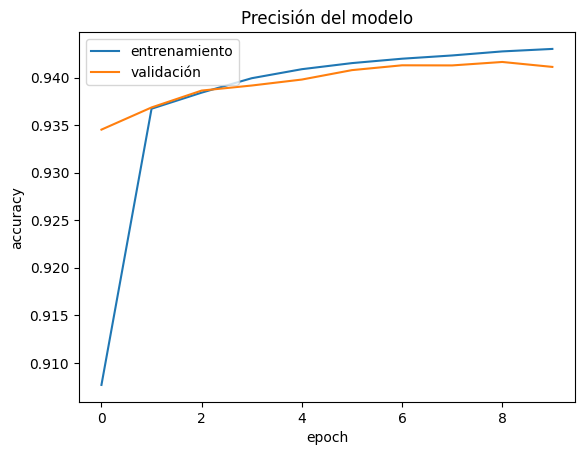

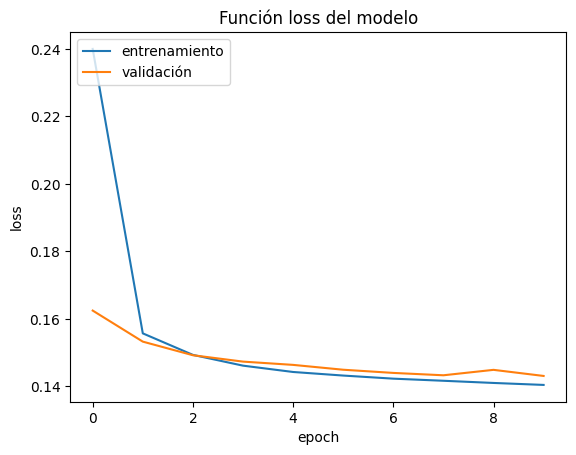

In [11]:
print(histories)
print(histories["M1"].history.keys())
history = histories["M1"]

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.ylim((0.8, 0.95))
plt.title('Precisión del modelo')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim((0, 5))
plt.title('Función loss del modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

#### Evaluar modelo M1 con el subconjunto de validación

In [12]:
def evaluar_modelo(y_reference, y_predicted):
  ## Aplicable para clasificacion multiclase
  cMatrix = confusion_matrix(y_reference, y_predicted)
  accuracy = accuracy_score(y_reference, y_predicted)
  kappa = cohen_kappa_score(y_reference, y_predicted)
  pScore = precision_score(y_reference, y_predicted, average=None)
  rScore = recall_score(y_reference, y_predicted, average=None)
  f1Score = f1_score(y_reference, y_predicted, average=None)

  print("Confusion matrix:\n", cMatrix)
  print("\nExactitud (accuracy): %.3f," % accuracy)
  print("\nKappa de Cohen: %.3f," % kappa)
  #print("\nROC AUC raw: %.3f," % roc_auc_raw)
  #print("\nROC AUC: %.3f," % roc_auc)
  print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
  print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
  print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

In [13]:
yValidatePredicted_M1_raw = M1.predict(xValidate)
yValidatePredicted_M1_class = yValidatePredicted_M1_raw.argmax(axis=-1)

evaluar_modelo(yValidate, yValidatePredicted_M1_class)

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Confusion matrix:
 [[42259    96  2325]
 [   78 27985    65]
 [ 2249    63  7692]]

Exactitud (accuracy): 0.941,

Kappa de Cohen: 0.898,

Clase 1. Selectividad (precision): 0.948, especificidad (recall): 0.946, f1: 0.947

Clase 2. Selectividad (precision): 0.994, especificidad (recall): 0.995, f1: 0.995

Clase 3. Selectividad (precision): 0.763, especificidad (recall): 0.769, f1: 0.766


Entrenar modelo ANN con hiperparametros ver. 2 (M2)

In [14]:
## Configurar el modelo
M2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
M2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print('TensorFlow version:', tf.version.VERSION)
print(M2.summary())

histories['M2']  = model_fit(M2, xTrain, yTrain,
                             xValidate, yValidate,
                             epochs=10, batch=50)


TensorFlow version: 2.17.1


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203 (812.00 B)

 Trainable params: 203 (812.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9155 - loss: 0.2205 - val_accuracy: 0.9365 - val_loss: 0.1543
Epoch 2/10
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.9379 - loss: 0.1513 - val_accuracy: 0.9389 - val_loss: 0.1498
Epoch 3/10
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9395 - loss: 0.1473 - val_accuracy: 0.9388 - val_loss: 0.1482
Epoch 4/10
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9401 - loss: 0.1464 - val_accuracy: 0.9407 - val_loss: 0.1482
Epoch 5/10
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9406 - loss: 0.1454 - val_accuracy: 0.9405 - val_loss: 0.1468
Epoch 6/10
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9407 - loss: 0.1457 - val_accuracy: 0.9406 - val_loss: 0.1458
Epoch 7/10
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9411 - loss: 0.1445 - val_accuracy: 0.9387 - val_loss: 0.1474
Epoch 8/10
13250/13250 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accur

#### Guardado del modelo M2 en Google Drive

In [15]:
ruta_modelo_M2 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_ANN_M2.keras"
print(ruta_modelo_M2)

M2.save(ruta_modelo_M2)

/content/drive/MyDrive/Colab Data/ESE_2015_ANN_M2.keras


#### Evaluar modelo M2 con el subconjunto de validación

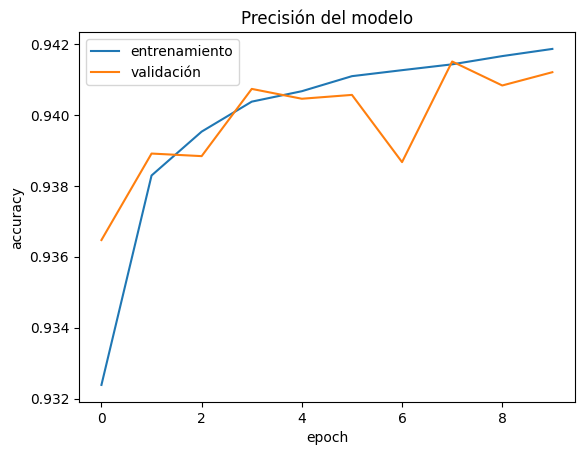

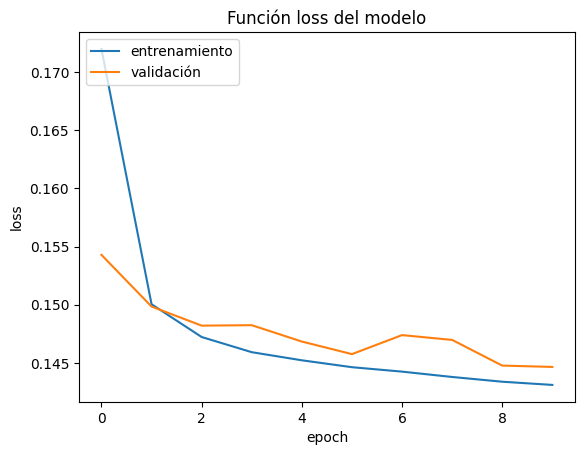

In [16]:
history = histories["M2"]

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.ylim((0.8, 0.95))
plt.title('Precisión del modelo')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim((0, 5))
plt.title('Función loss del modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [17]:
yValidatePredicted_M2_raw = M2.predict(xValidate)
yValidatePredicted_M2_class = yValidatePredicted_M2_raw.argmax(axis=-1)

evaluar_modelo(yValidate, yValidatePredicted_M2_class)

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Confusion matrix:
 [[42239    97  2344]
 [   84 27988    56]
 [ 2220    68  7716]]

Exactitud (accuracy): 0.941,

Kappa de Cohen: 0.899,

Clase 1. Selectividad (precision): 0.948, especificidad (recall): 0.945, f1: 0.947

Clase 2. Selectividad (precision): 0.994, especificidad (recall): 0.995, f1: 0.995

Clase 3. Selectividad (precision): 0.763, especificidad (recall): 0.771, f1: 0.767


### A partir de la evaluación con datos de validación se elegio el modleo M2
#### Evaluación con datos de control

In [18]:
M_elegido = M2

yTestPredicted_M_elegido_raw = M_elegido.predict(xTest)
yTestPredicted_M_elegido_class = yTestPredicted_M_elegido_raw.argmax(axis=-1)

evaluar_modelo(yTest, yTestPredicted_M_elegido_class)

2588/2588 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Confusion matrix:
 [[42518   115  2197]
 [   74 27907    57]
 [ 2151    41  7752]]

Exactitud (accuracy): 0.944,

Kappa de Cohen: 0.903,

Clase 1. Selectividad (precision): 0.950, especificidad (recall): 0.948, f1: 0.949

Clase 2. Selectividad (precision): 0.994, especificidad (recall): 0.995, f1: 0.995

Clase 3. Selectividad (precision): 0.775, especificidad (recall): 0.780, f1: 0.777


#### Prediccion para 2015

In [19]:
x_features_2015_full = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = M_elegido.predict(x_features_2015_full)
print(predicted_2015)

25879/25879 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step
[[9.9584168e-01 6.3889346e-04 3.5193977e-03]
 [9.9612004e-01 2.7394984e-04 3.6060289e-03]
 [9.9349380e-01 3.0450261e-04 6.2016365e-03]
 ...
 [9.9868214e-01 2.9296603e-04 1.0248892e-03]
 [9.9760789e-01 4.9011532e-04 1.9019317e-03]
 [9.9807894e-01 3.8757300e-04 1.5335396e-03]]


#### Visualizar predicción 2015

Predicción de clases


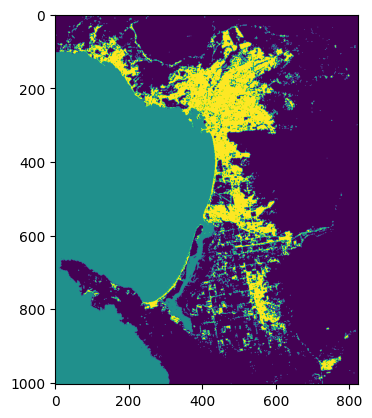

Probabilidad de presencia del espacio construido


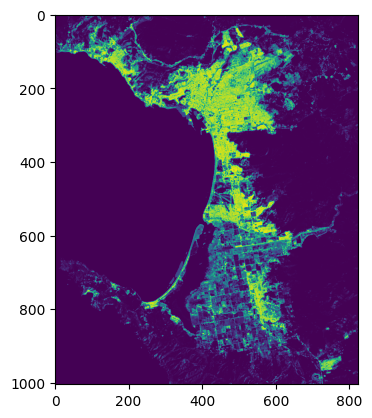

In [20]:
print('Predicción de clases')
predicted_2015_class = predicted_2015.argmax(axis=-1)
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

print('Probabilidad de presencia del espacio construido')
predicted_2015_probability = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (predicted_2015_probability).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

#### Guardar resultados en Numpy array en Google Drive

In [21]:
ruta_clases_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_clasificado.npy"
ruta_probabilidad_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_probabilidad.npy"
print(ruta_clases_2015)
print(ruta_probabilidad_2015)

np.save(ruta_clases_2015, predicted_2015_class_re)
np.save(ruta_probabilidad_2015, predicted_2015_probability)


/content/drive/MyDrive/Colab Data/ESE_2015_clasificado.npy
/content/drive/MyDrive/Colab Data/ESE_2015_probabilidad.npy


#### Preparar guardado en GeoTIFF

In [22]:
def write_geotiff(arr, filename, proj, transform):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32
    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(proj)
    out_ds.SetGeoTransform(transform)
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)


sr = osr.SpatialReference()
sr.ImportFromEPSG(int(projection_text.replace(projection_text[:5], '')))


## Nota: todos arrays deben ser de mismo número de pixeles de ancho y alto
## solo se calculan para target 2015

ancho_px_esperado = math.ceil((limites_utm[1] - limites_utm[0]) / pixel)
print('Ancho total esperado (pixeles)', ancho_px_esperado)
ancho_px_observado = array_target_2015.shape[1]
print('Ancho total observado (pixeles)', ancho_px_observado)
pixel_x = pixel * ancho_px_esperado / ancho_px_observado

alto_px_esperado = math.ceil((limites_utm[3] - limites_utm[2]) / pixel)
print('Alto total esperado (pixeles)', alto_px_esperado)
alto_px_observado = array_target_2015.shape[0]
print('Alto total observado (pixeles)', alto_px_observado)
pixel_y = pixel * alto_px_esperado / alto_px_observado

geotrans = [limites_utm[0], pixel_x, 0, limites_utm[3], 0, -pixel_y]

print(geotrans)
#print(sr)
print(sr.ExportToWkt())

Ancho total esperado (pixeles) 824
Ancho total observado (pixeles) 824
Alto total esperado (pixeles) 1005
Alto total observado (pixeles) 1005
[523989, 30.0, 0, 3532709, 0, -30.0]
PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


#### Guardar como GeoTIFFs en Google Drive

In [23]:
ruta_clases_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_clasificado.tif"
print(ruta_clases_2015_tif)

ruta_probabilidad_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_probabilidad.tif"
print(ruta_probabilidad_2015_tif)

write_geotiff(predicted_2015_class_re, filename=ruta_clases_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(predicted_2015_probability, filename=ruta_probabilidad_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)

/content/drive/MyDrive/Colab Data/ESE_2015_clasificado.tif
/content/drive/MyDrive/Colab Data/ESE_2015_probabilidad.tif
